### Plans & Ideas
* use a part of the data
* sPlot weights as a new feature
  * doesn't make any sense in search for an unlnown signal, but might be useful in reducing bkgr
* uniformity over bkgr
  * handmade losses to prevent similarities between sig and bkgr mass distribution
  * checking it with tests
* weighted AUC
* Focal Loss - https://arxiv.org/abs/1708.02002
* something from tau->3mu
* calibration
* dR antimatching as bkgr samples
* study the effect of including nB - mind that it might introduce simulation dependance of the model!
* add reflections as multiclass


### Import libraries

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import graphviz
import itertools

from IPython.display import Image        

from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model, metrics, tree, ensemble
from sklearn.preprocessing import scale, StandardScaler, PolynomialFeatures
from sklearn import utils
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif

# from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, classification_report, matthews_corrcoef

import lightgbm as lgb
import xgboost as xgb
import shap

# from hep_ml import uboost, gradientboosting as ugb, losses

# import pyDOE
%pylab inline  

sns.__version__

Populating the interactive namespace from numpy and matplotlib


'0.9.0'

### **Getting data**

In [59]:
MC   = pd.read_pickle('MC_pair_dR_psi_renamed.pkl')
# data    = pd.read_pickle('data_B0_e3de87.pkl')
data    = pd.read_pickle('data_B0_e3de87_nB_4000.pkl')

MC_vars = ["dR_mu1", "dR_mu2", "dR_pi1", "dR_pi2", "dR_K1", "dR_K2",
           "dR_mu1_vv", "dR_mu2_vv", "dR_pi1_vv", "dR_pi2_vv", "dR_K1_vv", "dR_K2_vv",
           'gen_phi_mass', 'delta_phi_mass',
           "BU_reflmass1_Cjp", "BU_reflmass2_Cjp"] 

MC.shape, data.shape

((230149, 50), (183406, 34))

In [60]:
data.columns

Index(['psi_eta', 'BU_pvdistsignif2_Cjp', 'mu_1_pt', 'PI2_eta', 'BU_pt_Cjp',
       'K1_pt', 'BU_vtxprob_Cjp', 'mu_2_eta', 'phi_eta', 'BU_mass_Cjp',
       'phi_pt', 'BU_pvdistsignif3_Cjp', 'nB', 'mu_2_pt', 'JP_pt',
       'JPSI_pvcos2_Cmumu', 'K2_eta', 'JPSI_vtxprob_Cmumu', 'K2_pt',
       'JPSI_pvdistsignif2_Cmumu', 'JPSI_mass_Cmumu', 'psi_pt', 'PI2_pt',
       'BU_eta_Cjp', 'PHI_mass_Cjp', 'psi_mass_Cjp', 'mu_1_eta', 'K1_eta',
       'BU_pvcos2_Cjp', 'PI1_pt', 'PI1_eta', 'PV_bestBang_RF_CL', 'JP_eta',
       'PIPI_mass_Cjp'],
      dtype='object')

In [61]:
#### ----- This we would do in the first example case

matching_mask = ((MC[['dR_mu1', 'dR_mu1_vv']].min(axis=1) < 0.01) & (MC[['dR_mu2', 'dR_mu2_vv']].min(axis=1) < 0.01) & (MC[['dR_pi1', 'dR_pi1_vv']].min(axis=1) < 0.01) &
                 (MC[['dR_pi2', 'dR_pi2_vv']].min(axis=1) < 0.01) & (MC[['dR_K1', 'dR_K1_vv']].min(axis=1) < 0.01) & (MC[['dR_K2', 'dR_K2_vv']].min(axis=1) < 0.01))
signal = MC[matching_mask]


# bkgr = (data[data['BU_mass_Cjp'].between(sig_window['BU_mass_Cjp'][1], sig_window['BU_mass_Cjp'][1] + 0.2) | 
#             data['BU_mass_Cjp'].between(sig_window['BU_mass_Cjp'][0] - 0.2, sig_window['BU_mass_Cjp'][0])]   ) # sidebands

# bkgr = data[data['BU_mass_Cjp'].between(5.45, 5.55) | data['BU_mass_Cjp'].between(5.1, 5.25)] # sidebands


mass_mask_for_bkgr = np.array([True] * data.shape[0])
sig_window = {'BU_mass_Cjp': [5.366 - 0.1, 5.366 + 0.1]}
### compose a mass window mask
for key, value in sig_window.items():
    mass_mask_for_bkgr &= ((data[key] > value[0] - 0.2) & (data[key] < value[0])) | ( (data[key] > value[1]) & (data[key] < value[1] + 0.2))
    
bkgr = data[mass_mask_for_bkgr]



#### ----- This is for a conventional train-on-MC way

# signal = data[data['BU_mass_Cjp'].between(5.3, 5.47)] # our signal region
# bkgr = data[data['BU_mass_Cjp'].between(5.2, 5.3) | data['BU_mass_Cjp'].between(5.47, 5.55)] # sidebands
# dR_vars = []

In [62]:
signal.shape

(85465, 50)

### **Final dataframe for training**

In [63]:
data.columns

Index(['psi_eta', 'BU_pvdistsignif2_Cjp', 'mu_1_pt', 'PI2_eta', 'BU_pt_Cjp',
       'K1_pt', 'BU_vtxprob_Cjp', 'mu_2_eta', 'phi_eta', 'BU_mass_Cjp',
       'phi_pt', 'BU_pvdistsignif3_Cjp', 'nB', 'mu_2_pt', 'JP_pt',
       'JPSI_pvcos2_Cmumu', 'K2_eta', 'JPSI_vtxprob_Cmumu', 'K2_pt',
       'JPSI_pvdistsignif2_Cmumu', 'JPSI_mass_Cmumu', 'psi_pt', 'PI2_pt',
       'BU_eta_Cjp', 'PHI_mass_Cjp', 'psi_mass_Cjp', 'mu_1_eta', 'K1_eta',
       'BU_pvcos2_Cjp', 'PI1_pt', 'PI1_eta', 'PV_bestBang_RF_CL', 'JP_eta',
       'PIPI_mass_Cjp'],
      dtype='object')

In [64]:
drop_vars = []
drop_masses = ['BU_mass_Cjp'] # , 'PHI_mass_Cjp', 'psi_mass_Cjp'
# drop_vars = ['nB']
# dR_vars = ['dR_mu1', 'dR_mu2', 'dR_pi1', 'dR_pi2', 'dR_K1', 'dR_K2']   # delta R variables for MC matching


signal = signal.drop(drop_vars + MC_vars, axis=1, inplace=False)
bkgr = bkgr.drop(drop_vars, axis=1, inplace=False)[signal.columns]

In [65]:
print(f'Signal shape: {signal.shape[0]}\nBkgr shape: {bkgr.shape[0]}')

Signal shape: 85465
Bkgr shape: 107355


In [66]:
min_shape = min(bkgr.shape[0], signal.shape[0])

bkgr = utils.shuffle(bkgr, random_state=123)[:min_shape] 
signal = utils.shuffle(signal, random_state=123)[:min_shape] 

### make target labels and append sig with bkgr
bkgr['target'] = [0]*bkgr.shape[0]
signal['target'] = [1]*signal.shape[0]
df = bkgr.append(signal)


print('Sig/bkgr shapes:', signal.shape, bkgr.shape)
print('Dataframe shape:', df.shape)
# print('\nNow better')

Sig/bkgr shapes: (85465, 35) (85465, 35)
Dataframe shape: (170930, 35)


In [67]:
signal.head()

,BU_pvdistsignif2_Cjp,mu_1_pt,PI2_eta,psi_pt,BU_pt_Cjp,K1_pt,BU_vtxprob_Cjp,mu_2_eta,phi_eta,BU_mass_Cjp,...,BU_eta_Cjp,PHI_mass_Cjp,mu_1_eta,K1_eta,BU_pvcos2_Cjp,PI1_pt,PI1_eta,PV_bestBang_RF_CL,PIPI_mass_Cjp,target
86146,34.940659,5.453611,0.265759,13.636699,19.291096,3.594519,0.785954,0.552614,0.662162,5.370573,...,0.538164,1.023522,0.386747,0.667702,0.999947,1.115630,0.533379,0.990075,0.567498,1
100649,49.011452,6.367651,-0.202097,20.733572,22.805780,1.370378,0.768976,-0.026840,-0.153419,5.368879,...,-0.088314,1.021317,-0.158899,-0.154635,0.999993,1.926887,-0.060682,0.962013,0.537003,1
127651,36.040894,4.066106,-0.241988,13.944258,20.421901,3.410103,0.246535,-0.170916,-0.281725,5.375604,...,-0.303297,1.020432,-0.581895,-0.275122,0.999931,0.858499,-0.293341,0.952052,0.557308,1
63633,35.290149,4.752998,1.099993,13.951531,15.678455,0.878177,0.323415,1.386702,0.908750,5.363447,...,1.181489,1.020333,0.913298,0.980329,0.999908,1.668320,1.218490,0.991973,0.553832,1
88638,18.093650,11.335234,1.064354,19.797000,24.913472,2.844850,0.185708,0.798155,0.883932,5.304771,...,0.829493,1.016083,0.774745,0.874692,0.999833,1.845885,0.869002,0.998174,0.413901,1


In [68]:
bkgr.head()

,BU_pvdistsignif2_Cjp,mu_1_pt,PI2_eta,psi_pt,BU_pt_Cjp,K1_pt,BU_vtxprob_Cjp,mu_2_eta,phi_eta,BU_mass_Cjp,...,BU_eta_Cjp,PHI_mass_Cjp,mu_1_eta,K1_eta,BU_pvcos2_Cjp,PI1_pt,PI1_eta,PV_bestBang_RF_CL,PIPI_mass_Cjp,target
100535,13.801304,4.783218,-1.429140,14.197355,16.032899,1.051841,0.427981,-1.305769,-1.252376,5.104577,...,-1.288826,1.046430,-1.149843,-1.082824,0.999696,0.828158,-1.366132,0.900526,0.519014,0
111435,7.798567,8.231379,-1.230670,20.293591,22.949222,1.638792,0.143498,-1.035767,-0.872371,5.496811,...,-0.938151,1.042740,-0.802290,-0.841257,0.999817,2.560135,-0.850055,0.901661,0.757351,0
74951,7.251884,8.010067,0.805393,24.023467,27.372383,1.736688,0.353561,0.454365,0.438764,5.152878,...,0.546077,1.048947,0.682589,0.505490,0.999876,1.292146,0.634489,0.806409,0.349048,0
88599,10.806287,11.834246,1.085726,25.496441,28.165710,1.356974,0.472394,1.279557,1.167453,5.107415,...,1.169835,1.001253,1.035679,1.207118,0.999967,2.008672,1.324845,0.683427,0.521514,0
67346,17.613854,7.849614,-0.994761,16.283725,18.628675,1.253249,0.808722,-1.035296,-1.089074,5.244349,...,-1.228716,1.036407,-1.382328,-1.061873,0.999404,2.413036,-1.221811,0.926273,0.555908,0


 ### **Drop nan, shuffle and split into X (features) and y (targets)**

In [69]:
# print ('Nan indices:\n ', np.argwhere(np.isnan(df.values)), '\n', sum(np.isnan(df.values)))
df = df.dropna(inplace=False) 

df = utils.shuffle(df, random_state=123)
X = df.iloc[:, :-1]
y = df['target']

In [70]:
print(f'NaNs in features:\n{df.columns[3]}, {df.columns[17]}')

NaNs in features:
psi_pt, K2_eta


### **Train / Test split**
##### (with optional Oversampling and Poly features)

In [71]:
# ros = RandomOverSampler(random_state=123)
# X_resampled, y_resampled = ros.fit_sample(X, y)

# poly = PolynomialFeatures(2)
# X_poly = poly.fit_transform(X)
# predict_poly = poly.fit_transform(predict.drop(mass_vars, axis=1, inplace=False))
# X_resampled, y_resampled = X_poly.copy(), y.copy()

# (X_train, X_test, y_train, y_test) = train_test_split(X_resampled, y_resampled,
#                                      test_size=0.2, 
#                                      random_state=123)

In [72]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y,
                                     test_size=0.2, 
                                     random_state=123, stratify=y)

train_masses = X_train[['BU_mass_Cjp', 'PHI_mass_Cjp', 'psi_mass_Cjp']]
X_train = X_train.drop(columns=drop_masses)

test_masses = X_test[['BU_mass_Cjp', 'PHI_mass_Cjp', 'psi_mass_Cjp']]
X_test = X_test.drop(columns=drop_masses)

In [73]:
y_train.value_counts()

1    68340
0    68340
Name: target, dtype: int64

### **Predict data**

In [74]:
mass_mask_for_prediction = np.array([True] * data.shape[0])

### compose a mass window mask
for key, value in sig_window.items():
    mass_mask_for_prediction &= (data[key] > value[0]) & (data[key] < value[1]) 
    
predict = data[mass_mask_for_prediction]

In [75]:
# print ('Nan indices:\n ', np.argwhere(np.isnan(predict.values)), '\n', sum(np.isnan(predict.values)))
predict = predict.dropna(inplace=False)

In [76]:
print(f'NaNs in features:\n   {predict.columns[11]}')

NaNs in features:
   BU_pvdistsignif3_Cjp


### **Splitting into predict features (same as before) and predict targets (masses)**

Matching columns to train sample **is damn important**! (otherwise behavior is unpredictable)

In [77]:
predict_masses = predict[['psi_mass_Cjp', 'PHI_mass_Cjp', 'BU_mass_Cjp']]
predict_data = predict.drop(drop_vars + drop_masses, axis=1, inplace=False)[X_train.columns] # here

# predict_data = StandardScaler().fit_transform(predict.drop(mass_vars, axis=1, inplace=False))

In [78]:
print(f'predict data shape: {predict_data.shape}')
print(f'train data shape: {X_train.shape}')
print(f'test data shape: {X_test.shape}')

predict data shape: (76011, 33)
train data shape: (136680, 33)
test data shape: (34170, 33)


### **LightGBM**

In [79]:
X_train.columns

Index(['BU_pvdistsignif2_Cjp', 'mu_1_pt', 'PI2_eta', 'psi_pt', 'BU_pt_Cjp',
       'K1_pt', 'BU_vtxprob_Cjp', 'mu_2_eta', 'phi_eta', 'psi_mass_Cjp',
       'phi_pt', 'BU_pvdistsignif3_Cjp', 'nB', 'mu_2_pt', 'JP_pt',
       'JPSI_pvcos2_Cmumu', 'K2_eta', 'JPSI_vtxprob_Cmumu', 'K2_pt', 'JP_eta',
       'JPSI_pvdistsignif2_Cmumu', 'JPSI_mass_Cmumu', 'PI2_pt', 'psi_eta',
       'BU_eta_Cjp', 'PHI_mass_Cjp', 'mu_1_eta', 'K1_eta', 'BU_pvcos2_Cjp',
       'PI1_pt', 'PI1_eta', 'PV_bestBang_RF_CL', 'PIPI_mass_Cjp'],
      dtype='object')

In [80]:
train_data = lgb.Dataset(X_train, label=y_train) #.drop(columns=['psi_mass_Cjp'])
test_data  = lgb.Dataset(X_test, label=y_test)

In [81]:
lgb_params = {'seed': 123, 
           'num_leaves': 30, 'max_depth': 10, 'subsample': .4, 'colsample_bytree': .9,
           'learning_rate': 0.06385698692724433,  'lambda': 2.511502718995968,'min_child_weight': 1
               }
# lgb_params['metric'] = ['auc', 'binary_logloss']

In [82]:
num_round = 100
lgb_booster = lgb.train(lgb_params, train_data, num_round) #, early_stopping_rounds=10, verbose_eval=True, valid_sets=[test_data]

In [83]:
prediction_test = lgb_booster.predict(X_test)
prediction_train = lgb_booster.predict(X_train)
prediction_lgb = lgb_booster.predict(predict_data)

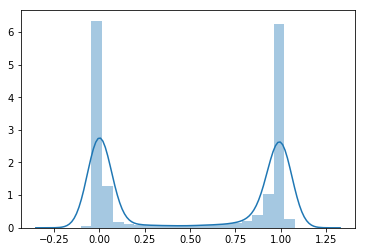

In [84]:
sns.distplot(prediction_test)

### **Metrics**

In [85]:
prob_cut = 0.5

In [86]:
print(classification_report(y_test, prediction_test > prob_cut))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     17085
           1       0.97      0.99      0.98     17085

   micro avg       0.98      0.98      0.98     34170
   macro avg       0.98      0.98      0.98     34170
weighted avg       0.98      0.98      0.98     34170



In [87]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


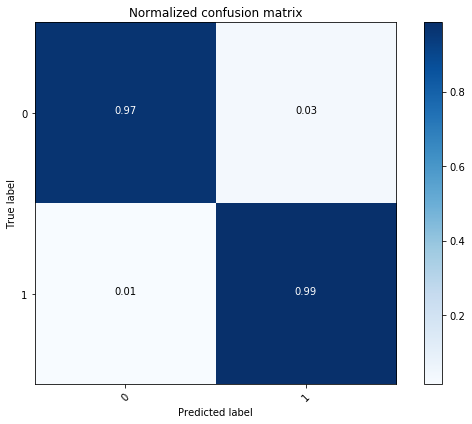

In [88]:
plt.figure(figsize=(8, 6))
plot_confusion_matrix(metrics.confusion_matrix(y_test, prediction_test > prob_cut), classes=['0', '1'], normalize=True,
                      title='Normalized confusion matrix')

In [89]:
print(f'ROC AUC = {metrics.roc_auc_score(y_test, prediction_test)}')
print(f'log loss = {metrics.log_loss(y_test,prediction_test)}')
print(f'Matthews correlation coefficient = {matthews_corrcoef(y_test, prediction_test > prob_cut):.3f}')

ROC AUC = 0.9967887875604163
log loss = 0.07903340608343913
Matthews correlation coefficient = 0.955


#### **ROC curve**

In [90]:
fpr, tpr, _ = roc_curve(y_test, prediction_test)
roc_auc = auc(fpr, tpr)

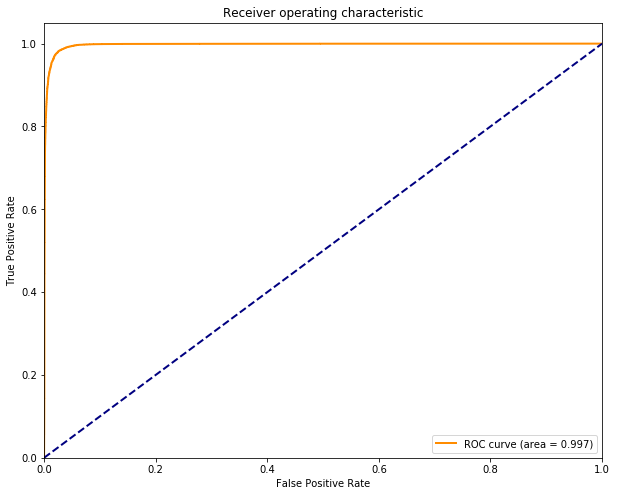

In [91]:
lw = 2
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

### **Final plots**

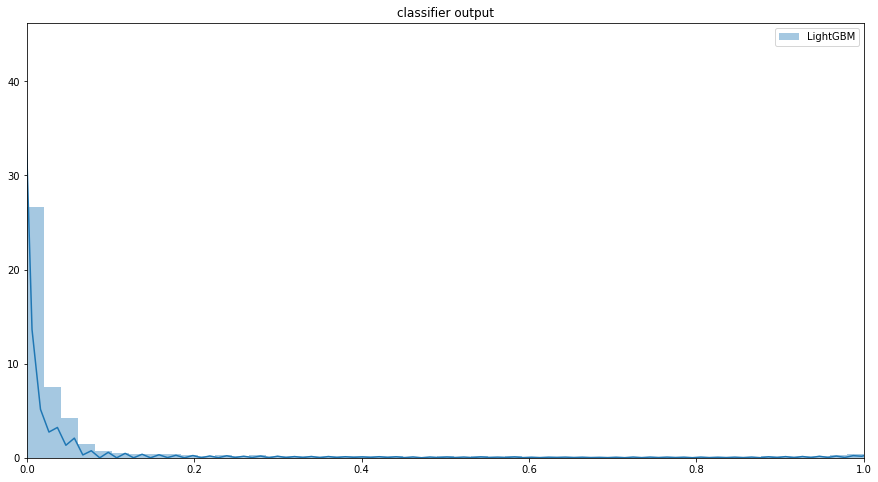

In [92]:
fig, ax = plt.subplots(figsize=(15,8))
# outputs = {'RF': prediction_RF, 'XGBoost': prediction_xgb, 'LogReg': prediction_logreg}
outputs = {'LightGBM': prediction_lgb}

for label, proba in outputs.items():
    sns.distplot(proba, ax=ax, bins=np.linspace(0., 1., num=50,  endpoint=True), label = label, kde=True, hist=True, norm_hist=True)
ax.set_xlim(0., 1.)
ax.set_title('classifier output')

plt.legend()
# plt.yscale('log')
# plt.ylim(10**(-1))

plt.show()

#### **Select masses according to classifier pradiction cut**

With cut > 0.8 survived 1542 out of 76011 for LightGBM


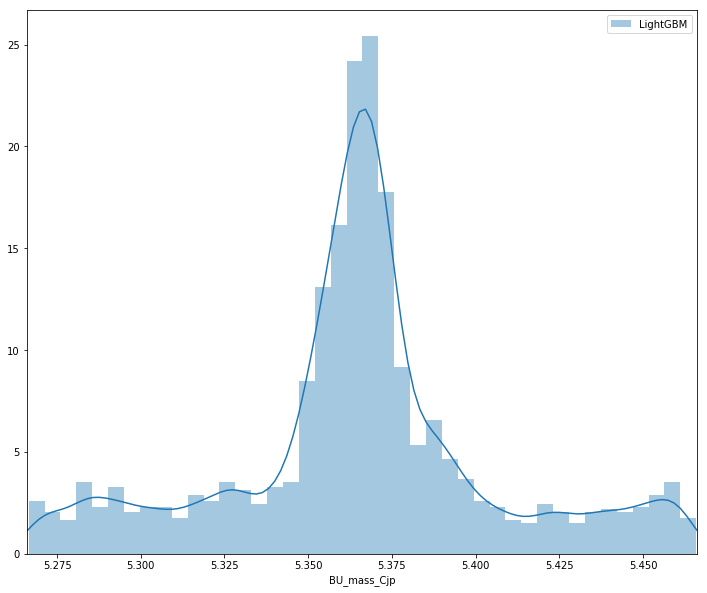

In [93]:
output_cut = 0.8
fig, ax = plt.subplots(figsize=(12,10))

for classifier, prediction in outputs.items():
    final_masses = predict_masses.iloc[prediction > output_cut] 
    print(f'With cut > {output_cut} survived {final_masses.shape[0]} out of {predict_masses.shape[0]} for {classifier}')
    sns.distplot(final_masses[('BU_mass_Cjp')], ax=ax, label = classifier, kde=True, hist=True, norm_hist=False)

ax.set_xlim(sig_window['BU_mass_Cjp'][0], sig_window['BU_mass_Cjp'][1])
# ax.set_title('classifier output')

plt.legend()
# plt.yscale('log')
# plt.ylim(10**(-1))

plt.show()

### **Look at masses**

In [94]:
X_train.columns

Index(['BU_pvdistsignif2_Cjp', 'mu_1_pt', 'PI2_eta', 'psi_pt', 'BU_pt_Cjp',
       'K1_pt', 'BU_vtxprob_Cjp', 'mu_2_eta', 'phi_eta', 'psi_mass_Cjp',
       'phi_pt', 'BU_pvdistsignif3_Cjp', 'nB', 'mu_2_pt', 'JP_pt',
       'JPSI_pvcos2_Cmumu', 'K2_eta', 'JPSI_vtxprob_Cmumu', 'K2_pt', 'JP_eta',
       'JPSI_pvdistsignif2_Cmumu', 'JPSI_mass_Cmumu', 'PI2_pt', 'psi_eta',
       'BU_eta_Cjp', 'PHI_mass_Cjp', 'mu_1_eta', 'K1_eta', 'BU_pvcos2_Cjp',
       'PI1_pt', 'PI1_eta', 'PV_bestBang_RF_CL', 'PIPI_mass_Cjp'],
      dtype='object')

In [95]:
output_cut = 0.5

In [96]:
vars = ['psi_mass_Cjp'] #   BU_mass_Cjp
test_psi_mass_sig = test_masses[vars].iloc[(prediction_test > output_cut) & (y_test.values == 1)]
test_psi_mass_bkgr = test_masses[vars].iloc[(prediction_test > output_cut) & (y_test.values == 0)]

train_psi_mass_sig = train_masses[vars].iloc[(prediction_train > output_cut) & (y_train.values == 1)]
train_psi_mass_bkgr = train_masses[vars].iloc[(prediction_train > output_cut) & (y_train.values == 0)]

# label_dict = {'test_sig': test_psi_mass_sig, 'test_bkgr': test_psi_mass_bkgr, 'train_sig': train_psi_mass_sig, 'train_bkgr': train_psi_mass_bkgr}
label_dict = {'train_bkgr': train_psi_mass_bkgr, 'test_bkgr': test_psi_mass_bkgr}

With cut > 0.5 survived 1927 out of 1927
With cut > 0.5 survived 527 out of 527


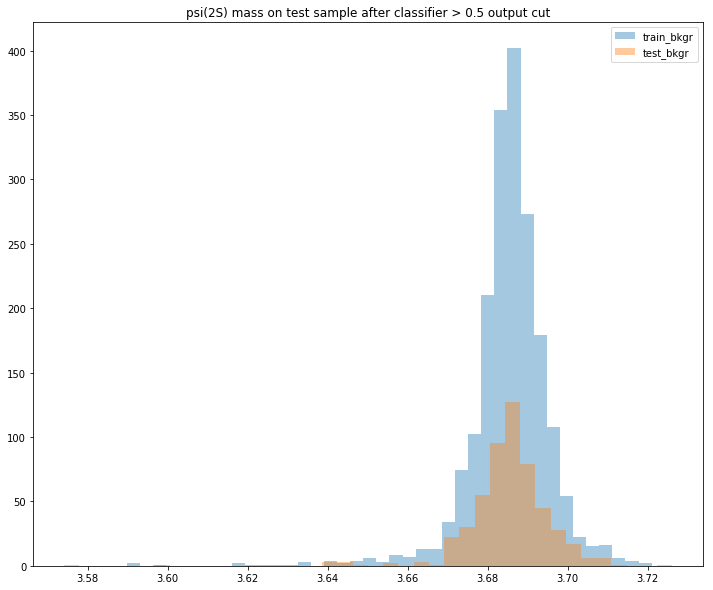

In [97]:
fig, ax = plt.subplots(figsize=(12,10))

# for masses, label in zip((train_psi_mass, test_psi_mass), ('train', 'test')):
for label, masses in label_dict.items():
#     final_masses = masses.iloc[prediction > output_cut] 
    final_masses = masses
    print(f'With cut > {output_cut} survived {final_masses.shape[0]} out of {masses.shape[0]}')
    sns.distplot(final_masses, ax=ax, label = label, bins = 40, kde=False, hist=True, norm_hist=False)

# ax.set_xlim(3.65, 3.72)
ax.set_title('psi(2S) mass on test sample after classifier > 0.5 output cut')

plt.legend()
# plt.yscale('log')
# plt.ylim(10**(-1))

plt.show()

### Scatterplots

In [98]:
mass_to_plot = 'psi_mass_Cjp'  # 'psi_mass_Cjp'    'BU_mass_Cjp'
mass_dict_train = {'mass': X_train[mass_to_plot], 'prediction': prediction_train, 'target': y_train}
mass_dict_test = {'mass': X_test[mass_to_plot], 'prediction': prediction_test, 'target': y_test}

mass_df_train = pd.DataFrame(mass_dict_train)
mass_df_test = pd.DataFrame(mass_dict_test)

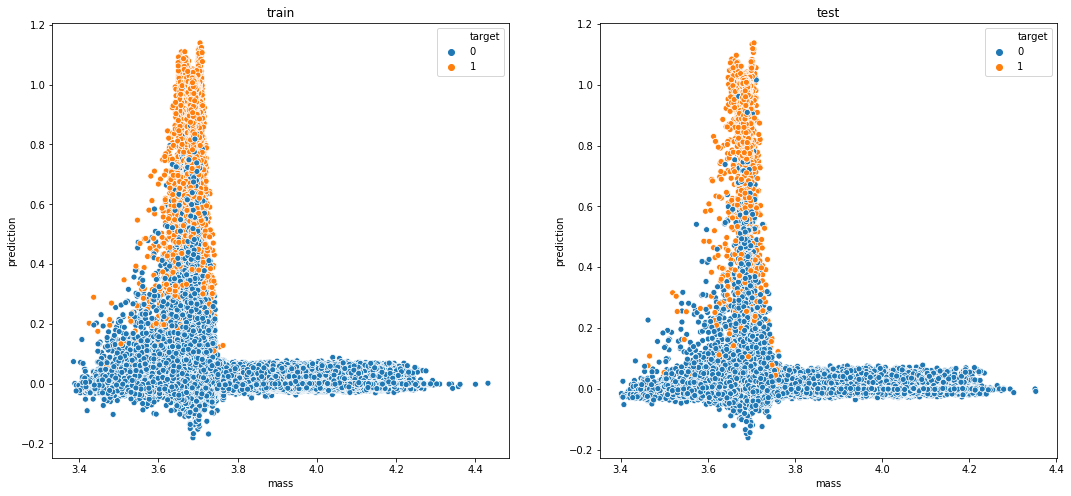

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
sns.scatterplot(data=mass_df_train, hue='target', x='mass', y='prediction', ax=ax1)
sns.scatterplot(data=mass_df_test, hue='target', x='mass', y='prediction', ax=ax2)

ax1.set_title('train')
ax2.set_title('test')
plt.show()

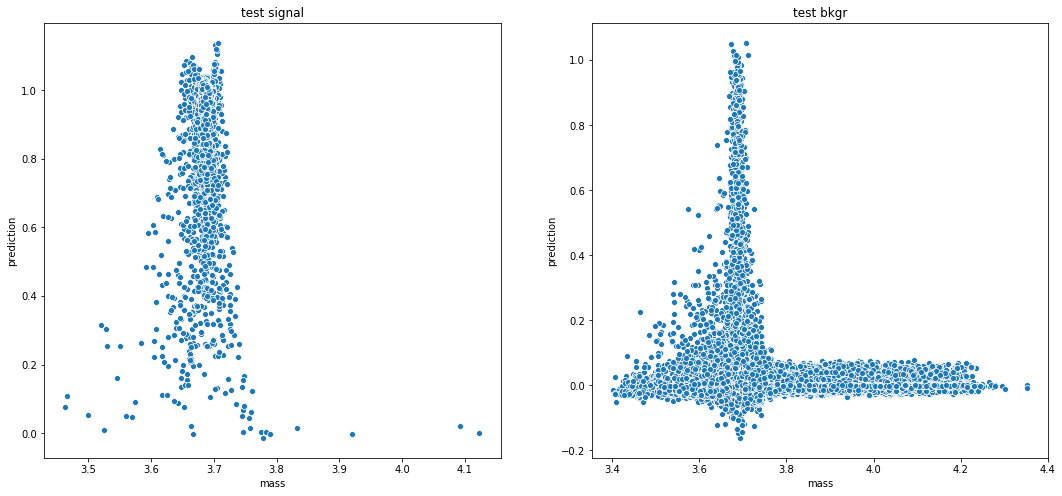

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
sns.scatterplot(x=mass_df_test[(mass_df_test.target == 1)].mass, y=mass_df_test[mass_df_test.target == 1].prediction, ax=ax1)
sns.scatterplot(x=mass_df_test[mass_df_test.target == 0].mass, y=mass_df_test[mass_df_test.target == 0].prediction, ax=ax2)

ax1.set_title('test signal')
ax2.set_title('test bkgr')

# ax1.set_ylim(0, 0.4)
# ax2.set_ylim(0, 0.4)

# ax1.set_xlim(3.65, 3.72)
# ax2.set_xlim(3.65, 3.72)

plt.show()

### **SHAP**

In [67]:
%%time
shap.initjs()

explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test_lgb)

CPU times: user 1min 46s, sys: 384 ms, total: 1min 47s
Wall time: 29.8 s


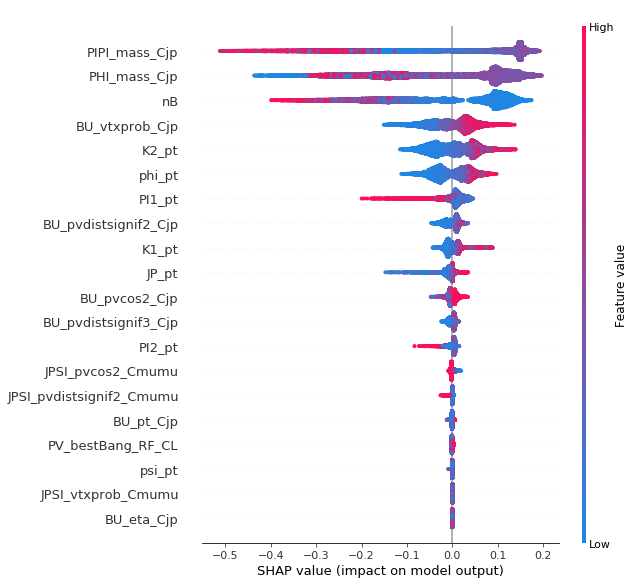

In [68]:
shap.summary_plot(shap_values, X_test_lgb)

In [61]:
explainer.expected_value

0.4999268470602373

In [62]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[6:700,:], X_test_lgb.iloc[6:700,:]) #0-bkgr, 6-sig, on sample wo psi mass

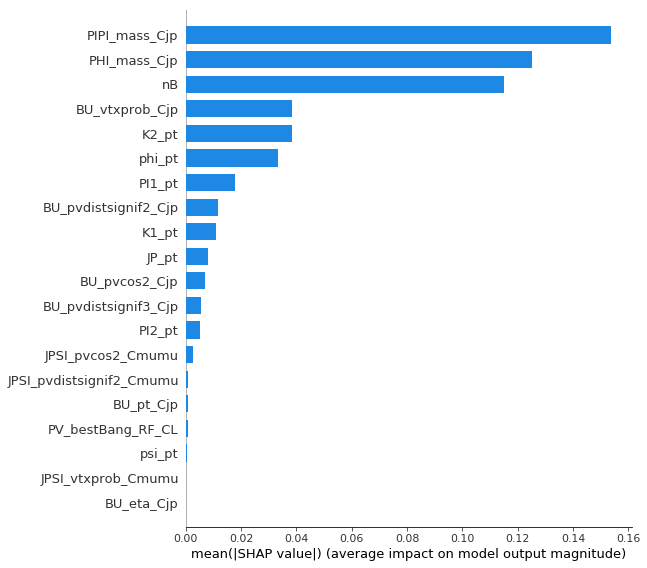

In [69]:
shap.summary_plot(shap_values, X_test_lgb, plot_type="bar")

### Feature selection with statistic tests

In [70]:
feature_scores_mi = mutual_info_classif(X_train_lgb, y_train)

for score, fname in sorted(zip(feature_scores_mi, X_train_lgb.columns), reverse=True)[:10]:
    print(fname, score)

feature_scores_mi /= np.max(feature_scores_mi)

# X_train_new = SelectKBest(mutual_info_classif, k=5).fit_transform(X_train_lgb, y_train)
# X_train_new.shape

PIPI_mass_Cjp 0.23066887717080453
PHI_mass_Cjp 0.22277114996946912
K2_pt 0.19675839880558255
K1_pt 0.19215836279692944
nB 0.1559347606941004
phi_pt 0.15186942959526206
JPSI_vtxprob_Cmumu 0.14425335864484423
JPSI_mass_Cmumu 0.14339629024289113
JPSI_pvdistsignif2_Cmumu 0.08847248285181797
K2_eta 0.08580614225446248


In [ ]:
### isn't precise, in case of regression captures only linear correleation
### you can see it below, where we have the most important features as the ones which are higher for the signal

feature_scores_f, p_values_f = f_classif(X_train_lgb, y_train)
feature_scores_f /= np.max(feature_scores_f)

for score, fname in sorted(zip(feature_scores_f, X_train_lgb.columns), reverse=True)[:10]:
    print(fname, score)
    
# X_train_new = SelectKBest(mutual_info_classif, k=5).fit_transform(X_train_lgb, y_train)
# X_train_new.shape

### **Prepare for training**

In [ ]:
X_train.columns

In [ ]:
uniform_features  = ['psi_mass_Cjp']
# train_features = X_train.columns.drop('psi_mass_Cjp')
train_features = ['PIPI_mass_Cjp', 'PHI_mass_Cjp', 'BU_pvdistsignif2_Cjp']
n_estimators = 20
base_estimator = DecisionTreeClassifier(max_depth=4)

In [ ]:
uboost_clf = uboost.uBoostClassifier(uniform_features=uniform_features, uniform_label=1,
                                     base_estimator=base_estimator, 
                                     n_estimators=n_estimators, train_features=train_features, 
                                     #efficiency_steps=12,
                                     n_threads=4)

In [ ]:
%%time
uboost_clf.fit(X_train[:], y_train[:])

In [ ]:
np.bincount(uboost_clf.predict(X_test))

In [ ]:
print(classification_report(y_test, uboost_clf.predict(X_test)))

### **2**

In [ ]:
flatnessloss = ugb.KnnFlatnessLossFunction(uniform_features, fl_coefficient=3., power=1.3, uniform_label=1)
ugbFL = ugb.UGradientBoostingClassifier(loss=flatnessloss, max_depth=3, 
                                       n_estimators=n_estimators, 
                                       learning_rate=0.1, train_features=train_features)

In [ ]:
%%time
ugbFL.fit(X_train[:], y_train[:])

In [ ]:
print(classification_report(y_test, ugbFL.predict(X_test)))

In [ ]:
print(f'ROC AUC = {metrics.roc_auc_score(y_test, uboost_clf.predict_proba(X_test)[:, 1])}')
print(f'log loss = {metrics.log_loss(y_test, uboost_clf.predict(X_test))}')
print(f'Matthews correlation coefficient = {matthews_corrcoef(y_test, uboost_clf.predict(X_test)):.3f}')